<h1>NLP Final Project</h1>

Course: **Natural Language Processing and Text Analytics**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# Library Import
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import nltk # Import stopwords with nltk.
nltk.download('stopwords')
from nltk.corpus import stopwords

# Classification libraries
import sys
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Metrics and confusion matrix modules
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /.../nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Data loading

## 1.1 Data retrieving

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Pyhon script used to scrape the Billboard song and artist name
# Suggested execution in terminal
"""
from bs4 import BeautifulSoup
import requests
import pandas as pd

#create dataframe
df_wiki = pd.DataFrame(columns = ['year', 'rank', 'song', 'artist'])

#specify start date(year)
year = 2000

#send requests from start date to 2021, as 2022 does not have year end charts yet
while year < 2022:
    #send GET request to wikipedia
    response = requests.get('https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_' + str(year))
    
    #scrape the website's table
    soup = BeautifulSoup(response.content,'html.parser')
    table = soup.find('table')
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        #concat data with dataframe if table has more than 2 columns, done to detect the right table on the website
        if cols != [] and len(cols) > 2:
            data = {'year': str(year), 'rank': str(cols[0]), 'song': str(cols[1]).replace('"', ''),'artist': str(cols[2])}
            df_wiki = pd.concat([df_wiki, pd.DataFrame(data, index=[0])])
    year += 1
    
df_wiki.to_csv('BillboardHot100.csv', index = False)

"""

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# Python script used to retrieve the lyrics of the songs for the both 'unpopular' and 'popular' dataset
# Suggested execution in terminal
# In[1]:
"""
import pandas as pd
from lyricsgenius import Genius
import re 
from requests.exceptions import Timeout

#genius = Genius("56jLXWAuduLtVnQs0AAhh67wbabeDc8d-AKgFaxCtLaXSepTnUhEXi2XLlOSfCay")
#artist = genius.search_artist("Andy Shauf ", max_songs=3, sort="title")
#print(artist.songs)
ds = pd.read_csv('unpop_songs.csv')
#ds1 = ds[1000:]
songs = ds['unpop_songs'].to_list()
artists = ds['artist'].to_list()

lyrics = []
def get_lyrics():
    # while len(lyrics) != len(end_df): #1
    genius = Genius("56jLXWAuduLtVnQs0AAhh67wbabeDc8d-AKgFaxCtLaXSepTnUhEXi2XLlOSfCay")
    genius.timeout = 15
    #genius.sleep_time = 40  # 2
    # or: Genius(token, timeout=15, sleep_time=40)
    for track in ds.values:
        retries = 0
        while retries < 3:
            try:
                song = genius.search_song(track[1], track[2])
            except Timeout as e:
                retries += 1
                continue
            if song is not None:
                lyrics_song = song.lyrics.replace("\n", " ") # remove \n -> backspace
                lyrics_song = re.sub("[\(\[].*?[\)\]]", "", lyrics_song) #remove texts between []
                lyrics.append(lyrics_song)
            else:
                lyrics.append("null")
            break
    return
get_lyrics()
ds['lyrics'] = lyrics        
ds.to_csv('unpop_songs_all.csv', index = False, header=False)

"""

## 1.2 Data merging 

In [3]:
# Load the dataset of songs appearing on the Billboard Hot 100 and setting the class popularity for the prediction task to 1
pos = pd.read_csv('/Users/wiktorialazarczyk/Downloads/NLP_Final_Project/BillboardHot100_with_lyrics_full.csv')
pos['popularity'] = 1

# Load the dataset of songs from artists appearing on the Billboard Hot 100 but that have not make it into the playlist
neg = pd.read_csv('/Users/wiktorialazarczyk/Downloads/NLP_Final_Project/Final_Unpop_Songs_With_Lyrics.csv')
# Setting the class popularity for the prediction task to 0
neg['popularity']= 0

# Rename col for future correct merge
neg['song'] = neg['unpop_song']
neg = neg.drop('unpop_song', axis=1)

# Remove songs present in the popular dataset
#print(neg.song.isin(pos.song))
neg = (neg[~neg.song.isin(pos.song)])

# Dataset merge
ds = pos.append(neg, ignore_index=True)
ds.reset_index(drop=True) #reset the index
#print(ds.shape)
#print(ds['popularity'].value_counts())

,Unnamed: 0,year,rank,song,artist,lyrics,popularity,lyrics_wo_stop
0,0,2000.0,1.0,Breathe,Faith Hill,Breathe Lyrics I can feel the magic floating i...,1,NaN
1,1,2000.0,2.0,Smooth,Santana featuring Rob Thomas,"Smooth Lyrics Man, it's a hot one Like seven i...",1,NaN
2,2,2000.0,3.0,Maria Maria,Santana featuring The Product G&B,"Maria Maria Lyrics Ladies and gents, turn up y...",1,NaN
3,3,2000.0,4.0,I Wanna Know,Joe,"I Wanna Know Lyrics Yeah Oh-oh, yeah Alright, ...",1,NaN
4,4,2000.0,5.0,Everything You Want,Vertical Horizon,Everything You Want Lyrics Somewhere there's s...,1,NaN
...,...,...,...,...,...,...,...,...
4212,3101,NaN,NaN,no manners,brs kash,no manners lyrics she gon' pull up whenever...,0,manners gon pull whenever tell love country gr...
4213,3102,NaN,NaN,/catorce,rauw alejandro,/catorce lyrics yeah-yeah-yeah-yeah-yeah-ye...,0,catorce yeahyeahyeahyeahyeahyeahyeahyeahyeahye...
4214,3103,NaN,NaN,cúrame,rauw alejandro,cúrame lyrics hace unos días me caí del ciel...,0,c rame hace unos d as ca del cielo t ere ell...
4215,3104,NaN,NaN,nostálgico,rauw alejandro,"rvssian, rauw alejandro & chris brown - nostál...",0,rvssian rauw alejandro chris brown nost lgic...


## 1.3 Data pre-processing 

In [4]:
# Null values
print('number of null values:')
print(ds['lyrics'].isna().value_counts()) # Number of null values
ds = ds[ds['lyrics'].notna()] # remove null values 
ds.reset_index(drop=True) # reset the index
ds = ds.apply(lambda x: x.astype(str).str.lower()) # convert all ds to lowercase

number of null values:
False    4204
True       13
Name: lyrics, dtype: int64


In [5]:
#ds.apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')) # Remove emoji from text
#ds['rank'] = ds['rank'].astype(int) # convert back to int
#ds = ds.drop("Unnamed: 0", axis=1) # Drop col

# remove stopwords, punctuation
stop = stopwords.words('english')
stop.append('lyrics') # add lyrics to the list
stop.append('embed') # add embed to the list

ds['song'] = ds['song'].str.replace(r"'", "’")

# remove numbers
ds['song'] = ds['song'].str.replace('\d+', ' ')
ds['lyrics'] = ds['lyrics'].str.replace('\d+', ' ')

# remove stop words
ds['lyrics_wo_stop'] = ds['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#remove punctuation
ds['lyrics_wo_stop'] = ds['lyrics_wo_stop'].str.replace(r'[^\w\s]+', '') 
 
#remove emojis
ds['lyrics_wo_stop'] = ds['lyrics_wo_stop'].str.replace(r'[^(a-z|A-Z)]', ' ', regex=True).astype('str')

#ds['lyrics_wo_stop'].astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))


### Further cleaning

# select the "faulty row" if the first "song" character is not the same as the first char in lyrics
ds1 = ds.loc[ds['song'].str[:1] != ds['lyrics'].str[:1]] 
# select the "faulty row" if the first "artist" character is not the same as the first char in lyrics
ds2 = ds1.loc[ds1['artist'].str[:1] != ds1['lyrics'].str[:1]]
index_list = ds2.index.to_list()
# index_list
ds = ds.drop(index_list)
print("Dataset size (popular and unpopular data together): ", len(ds))

Dataset size (popular and unpopular data together):  4118


In [6]:
# Class balancing 
# Sample just 1900 of the unpopular songs to make the dataset more balanced

split_neg = ds[ds['popularity'] == "0"] # pick pop ds
split_pos = ds[ds['popularity'] == "1"] # pick unpop ds
split_neg = split_neg.sample(frac=1).reset_index(drop=True)
split_neg = split_neg.head(1900)
ds = split_pos.append(split_neg, ignore_index=True)
print("Final distribution and size of the dataset to train and test the models: ")
print("Number of rows:", ds.shape[0])
print("Number of features: ", ds.shape[1])
print(ds['popularity'].value_counts())

Final distribution and size of the dataset to train and test the models: 
Number of rows: 3801
Number of features:  8
1    1901
0    1900
Name: popularity, dtype: int64


In [7]:

#ds.apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')) # Remove emoji from text
#pop_song_ds = ds.drop("Unnamed: 0", axis=1) # Drop col

# Insert bucket labels 
ds_m = ds[ds['popularity'] == "1"] 
#pd.to_numeric(ds_m['rank'])
#ds_m['rank'].to_numeric()
#print(ds_m.dtypes)
ds['year'] = ds['year'].astype("float64")
ds_m['char_count'] = ds_m['lyrics'].str.len() # Add number of characters for each songs 

'''
# Length of songs visualization
# Show mean length of popular songs over the years
ds_m.sort_values(by=['char_count'], ascending=False)
ds_m_grouped = ds_m.groupby(['year']).mean()
#ds_m_grouped
sns.set(rc = {'figure.figsize':(15,8)})
sns.regplot(x=ds_m_grouped.index, y=ds_m_grouped['char_count'], color="#5dc2de").set_title('Average length of songs across the years')
sns.set
'''

'\n# Length of songs visualization\n# Show mean length of popular songs over the years\nds_m.sort_values(by=[\'char_count\'], ascending=False)\nds_m_grouped = ds_m.groupby([\'year\']).mean()\n#ds_m_grouped\nsns.set(rc = {\'figure.figsize\':(15,8)})\nsns.regplot(x=ds_m_grouped.index, y=ds_m_grouped[\'char_count\'], color="#5dc2de").set_title(\'Average length of songs across the years\')\nsns.set\n'

In [8]:
cols=['Unnamed: 0']
ds_m = ds_m.drop(cols, axis=1) # Drop col

In [9]:
# Setting the buckets 
# b_1 (Top tier) = 1-34 
# b_2 (Top tier) = 34-67 
# b_3 (Top tier) = 68-101 
ds_m['rank'] = ds_m['rank'].astype("float64")
ds_m['range'] = ""
ds_m['range'] = ds_m['range'].mask(ds_m['rank'].between(1,34), "b_1")
ds_m['range'] = ds_m['range'].mask(ds_m['rank'].between(34,67), "b_2")
ds_m['range'] = ds_m['range'].mask(ds_m['rank'].between(68,101), "b_3")

In [10]:
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

# Tokenization 
from nltk.tokenize import word_tokenize
def tokenize(column1):
    column1 = word_tokenize(column1)
    return column1

ds['lyrics_wo_stop'].dropna(inplace=True)
ds['lyrics_wo_stop'] = ds['lyrics_wo_stop'].apply(tokenize)

from nltk.stem import WordNetLemmatizer

# Defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
ds['lyrics_wo_stop']=ds['lyrics_wo_stop'].apply(lambda x:lemmatizer(x))

# Tokenization produces list so changing back to just words
def rejoin_words(tokenized_column):
    return ( " ".join(tokenized_column))

ds['lyrics_wo_stop'] = ds.apply(lambda x: rejoin_words(x['lyrics_wo_stop']), axis=1)

# Checking the distribution for the two classes
ds['popularity'].value_counts()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wiktorialazarczyk/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/wiktorialazarczyk/nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wiktorialazarczyk/nltk_data...


1    1901
0    1900
Name: popularity, dtype: int64

# 2. Binary Classification: 1st research question

In [11]:
# Define features and target
X = ds['lyrics_wo_stop']
Y = ds['popularity']

In [12]:
#divide the ds between train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle = True, stratify = Y)

In [13]:
#count vectorizer
#creating a count vectorizer. although stop words have already been removed, as an extra safety the parameter is set to remove english stopwords
cv = CountVectorizer(decode_error='ignore', 
                              stop_words='english', 
                              max_features=10000)   #consider 10000 top max_features ordered by term frequency

In [14]:
#Tf-Idf transformer
tfidf=TfidfTransformer() #norm= 'l2' as default

## 2.1 Logistic regression

In [15]:
#creating a pipeline for the logistic regression formed by: count vectorizer, tfifd transformer and logistic regression 
pipe_clf_lr = Pipeline(
    [('vect', cv),
     ('tfidf', tfidf), 
     ('clf', LogisticRegression( penalty='l2', solver='lbfgs', 
                                dual=False, tol=1e-3)), 
     ])

#training the model and obtaining the prediction
lr_clf = pipe_clf_lr.fit(X_train,y_train)
lr_predictions = pipe_clf_lr.predict(X_test)

In [16]:
#binary logistic regression classification report
print('binary logistic regression classification report')
print(classification_report(y_test,lr_predictions))

binary logistic regression classification report
              precision    recall  f1-score   support

           0       0.58      0.59      0.59       475
           1       0.58      0.57      0.58       476

    accuracy                           0.58       951
   macro avg       0.58      0.58      0.58       951
weighted avg       0.58      0.58      0.58       951



Linear Regression accuracy: 0.580441640378549


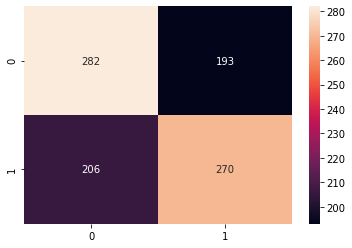

In [17]:
#binary logistic regression confusion matrix
lr_cm= confusion_matrix(y_test,lr_predictions)
lr_ac=accuracy_score(lr_predictions,y_test)
plt.title("")
sns.heatmap(lr_cm,annot=True,fmt="d" ,cbar=True)
print('Linear Regression accuracy:',lr_ac)

## 2.2 Gaussian NB Model

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer

#NB classification pipeline formed by: count vectorizer, tf-idf transformer, Funtion transformer and a Gaussian NB. 
#The function transformer is required as the dense data are required for the Gaussian NB instead of sparse data
pipe_clf_nb = Pipeline(
    [('vect', cv),
     ('tfidf', tfidf),
     ('f', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
     ('clf', GaussianNB()), 
     ])

#parameter grid for the Grid search. The same grid will also be used for the multi class classification
param = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
}

#Grid search to find the best parameters based on the score of f1-macro. 
#the evaluation is based on 10 cross-validation steps
score = 'f1_macro'
clf = GridSearchCV(pipe_clf_nb, param, cv=10, scoring=score)
#the best model is used to train the data
clf.fit(X_train, y_train)

#binary Gaussian NB classification report
print('binary Gaussian NB classification report')
print(classification_report(y_test, clf.predict(X_test), digits=2))

binary Gaussian NB classification report
              precision    recall  f1-score   support

           0       0.54      0.63      0.58       475
           1       0.56      0.47      0.51       476

    accuracy                           0.55       951
   macro avg       0.55      0.55      0.55       951
weighted avg       0.55      0.55      0.55       951



Gaussian Naive Bayes accuracy: 0.5488958990536278


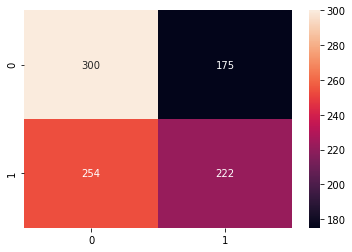

In [19]:
#binary Gaussian NB confusion matrix
nb_predictions = clf.predict(X_test)
nb_cm= confusion_matrix(y_test,nb_predictions)
nb_ac=accuracy_score(nb_predictions,y_test)
plt.title("")
sns.heatmap(nb_cm,annot=True,fmt="d" ,cbar=True)
print('Gaussian Naive Bayes accuracy:',nb_ac)

## 2.3 Random Forest Classifier

In [20]:
#relevant imports
from sklearn.ensemble import RandomForestClassifier

#creating a pipeline for the RF classifier formed by: tfifd transformer and RF classifier 

pipe_clf_rf = Pipeline(
    [('tfidf', tfidf),
     ('rf', RandomForestClassifier(n_estimators = 100, random_state = 0)), 
     ])

#parameter grid for the Grid search. The same grid will also be used for the multi class classification
grid= {'rf__n_estimators' : list(range(10,101,10)),
    'rf__max_features' : list(range(6,32,5)),
    'rf__criterion': ['gini', 'entropy']}

#Grid search to find the best parameters based on the score of f1-macro. 
#the evaluation is based on 10 cross-validation steps
clf = GridSearchCV(pipe_clf_rf, param_grid = grid, cv = 5, verbose=True, n_jobs=-1)

#vectorizing the features
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)

#training the best model
best_clf = clf.fit(X_train_vec, y_train)

rf_pred=best_clf.predict(X_test_vec)

#binary Gaussian NB classification report
print('binary Gaussian NB classification report')
print(classification_report(y_test, rf_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
binary Gaussian NB classification report
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       475
           1       0.62      0.55      0.58       476

    accuracy                           0.60       951
   macro avg       0.60      0.60      0.60       951
weighted avg       0.60      0.60      0.60       951



Random Forest classifier accuracy: 0.6035751840168244


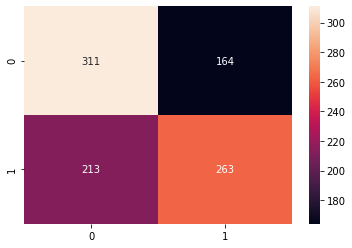

In [21]:
#binary Gaussian NB confusion matrix
rf_cm= confusion_matrix(y_test,rf_pred)
rf_ac=accuracy_score(rf_pred,y_test)
plt.title("")
sns.heatmap(rf_cm,annot=True,fmt="d" ,cbar=True)
print('Random Forest classifier accuracy:',rf_ac)

# 3. Multilabel classification: 2nd research question

In [22]:
#define features and target
X_m = ds_m['lyrics_wo_stop']
Y_m = ds_m['range']

In [23]:
#divide the popular song data set between train and test set
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, Y_m,shuffle=True,stratify=Y_m)

## 3.1 Logistic regression

In [24]:
#creating a pipeline for the logistic regression formed by: count vectorizer, tfifd transformer and logistic regression 
pipe_clf_lr = Pipeline(
    [('vect', cv),
     ('tfidf', tfidf), 
     ('clf', LogisticRegression( penalty='l2', solver='lbfgs', 
                                dual=False, tol=1e-3, multi_class='multinomial')), 
     ])

#training the model and making predictions
lr_clf_m = pipe_clf_lr.fit(X_train_m, y_train_m)
lr_predictions_m = pipe_clf_lr.predict(X_test_m)

#3-class logistic regression classification report
print('Logistic regression classification report')
print(classification_report(y_test_m,lr_predictions_m))

Logistic regression classification report
              precision    recall  f1-score   support

         b_1       0.32      0.31      0.31       153
         b_2       0.35      0.38      0.36       164
         b_3       0.37      0.35      0.36       159

    accuracy                           0.35       476
   macro avg       0.35      0.35      0.35       476
weighted avg       0.35      0.35      0.35       476



Linear Regression accuracy: 0.34663865546218486


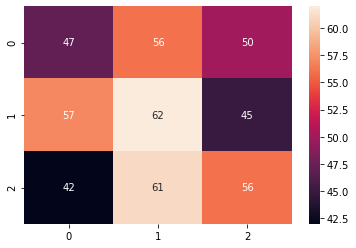

In [25]:
#3-class logistic regression confusion matrix
lr_cm= confusion_matrix(y_test_m,lr_predictions_m)
lr_ac=accuracy_score(lr_predictions_m,y_test_m)
plt.title("")
sns.heatmap(lr_cm,annot=True,fmt="d" ,cbar=True)
print('Linear Regression accuracy:',lr_ac)

## 3.2 Multinomial NB

In [26]:
#NB classification pipeline formed by: count vectorizer, tf-idf transformer and a Multinomial NB. 
pipe_clf_mnb = Pipeline(
    [('vect', cv),
     ('tfidf', tfidf),
     ('clf', MultinomialNB(alpha=0.6)), #alpha for smooting
     ])

#mnb_clf_m = pipe_clf_mnb.fit(X_train_m, y_train_m)
#mnb_predictions_m = pipe_clf_mnb.predict(X_test_m)

#Grid search to find the best parameters based on the score of f1-macro. 
#the evaluation is based on 10 cross-validation steps
score = 'f1_macro'
clf = GridSearchCV(pipe_clf_mnb, param, cv=10, scoring=score)
clf.fit(X_train_m, y_train_m)

#3-class NB classification report
print('NB classification report')
print(classification_report(y_test_m, clf.predict(X_test_m)))

NB classification report
              precision    recall  f1-score   support

         b_1       0.32      0.22      0.26       153
         b_2       0.34      0.35      0.35       164
         b_3       0.41      0.51      0.45       159

    accuracy                           0.36       476
   macro avg       0.36      0.36      0.35       476
weighted avg       0.36      0.36      0.35       476



Multinomial Naive Bayes accuracy: 0.3634453781512605


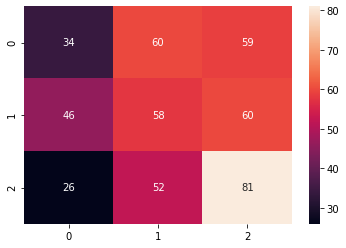

In [27]:
#3-class NB confusion matrix
nb_predictions = clf.predict(X_test_m)
nb_cm= confusion_matrix(y_test_m,nb_predictions)
nb_ac=accuracy_score(nb_predictions,y_test_m)
plt.title("")
sns.heatmap(nb_cm,annot=True,fmt="d" ,cbar=True)
print('Multinomial Naive Bayes accuracy:',nb_ac)

## 3.3 Random Forest classifier

In [28]:
#Here the same pipeline as in the RF binary classification is used
X_train_vec_m = cv.fit_transform(X_train_m)
X_test_vec_m = cv.transform(X_test_m)


#Grid search to find the best parameters based on the score of f1-macro. 
#the evaluation is based on 10 cross-validation steps
clf = GridSearchCV(pipe_clf_rf, param_grid = grid, cv = 5, verbose=True, n_jobs=-1)

#training the model and making predictions
best_clf_m = clf.fit(X_train_vec_m, y_train_m)

rf_pred=best_clf_m.predict(X_test_vec_m)

#3-class RF classification report
print('Random Forest classification report')
print(classification_report(y_test_m, rf_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Random Forest classification report
              precision    recall  f1-score   support

         b_1       0.32      0.31      0.32       153
         b_2       0.32      0.35      0.33       164
         b_3       0.33      0.29      0.31       159

    accuracy                           0.32       476
   macro avg       0.32      0.32      0.32       476
weighted avg       0.32      0.32      0.32       476



Random Forest classifier accuracy: 0.31932773109243695


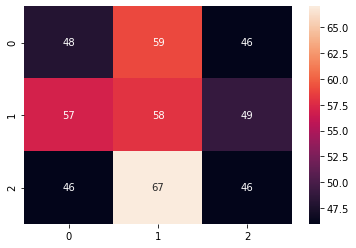

In [29]:
#3-class Random Forest confusion matrix
rf_cm= confusion_matrix(y_test_m,rf_pred)
rf_ac=accuracy_score(rf_pred,y_test_m)
plt.title("")
sns.heatmap(rf_cm,annot=True,fmt="d" ,cbar=True)
print('Random Forest classifier accuracy:',rf_ac)